In [1]:
import importlib
import time
import os
import pickle
import glob
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import integrate
from scipy import interpolate

In [2]:
from multi_loc import covariance, assimilate, utilities

In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [20]:
# tune_name = 'fine_obs'

# # save_dir = 'RK_tune'
# save_dir = 'fine_time'

tune_name = 'dense_obs_tune_R'

save_dir = 'dt_05'

home = os.path.expanduser("~")

save_dir = os.path.join(
    home,
    'Documents/python_code/multi_loc/notebooks/',
    save_dir)

tune_dir = os.path.join(save_dir, tune_name)

stdrd_dir = os.path.join(tune_dir, 'stdrd_loc')
smooth_dir = os.path.join(tune_dir, 'smooth_loc')

this_path = os.path.join(save_dir, 'Z_GT.npy')
Zgt = np.load(this_path)

this_path = os.path.join(save_dir, 'Z0_ens.npy')
Z0ens = np.load(this_path)

this_path = os.path.join(save_dir, 't_gt.npy')
t_gt = np.load(this_path)

# this_path = os.path.join(save_dir, 't_lr.npy')
# t_lr = np.load(this_path)

this_path = os.path.join(save_dir, 'run_vars.pkl')
with open(this_path, mode='rb') as f:
    run_vars = pickle.load(f)

In [21]:
for key, value in run_vars.items():
    print(key + ' = ' + str(value))
    exec(key + '=value')

Nz = 960
K = 32
I = 12
F = 15.0
b = 10.0
c = 2.5
alpha = 0.12414383561643835
beta = 0.013746194824961947
coarse = 8
Nez = 20
Nex = 500
dt_rk = 0.0020833333333333333
dt_lr = 0.1
dt_gt = 0.0020833333333333333
Tic = 24.0
Tlr = 4000
Tgt = 250


In [22]:
# if not os.path.exists(tune_dir):
#     os.mkdir(tune_dir)

# dt_trial_rk = 0.05/24
# dt_kf = 0.05
# dt_save = None
# Tkf = Tgt/5     #### Change this
# Tspin_index = 500
# Tspin = dt_kf * Tspin_index

# alpha_range = np.array([0, 0.01, 0.02, 0.04, 0.08], dtype='float')
# loc_range = np.array([5, 10, 15, 20, 30, 40, 50, 60], dtype='float')


# R_sd = 2
# everyH = 24
# Hz = np.eye(Nz)[::everyH]
# Ny = Hz.shape[0]
# Rz = np.eye(Ny) * R_sd**2

# fine_obs_dict = {'dt_trial_rk': dt_trial_rk,
#                  'dt_kf': dt_kf,
#                  'dt_save': dt_save,
#                  'Tkf': Tkf,
#                  'Tspin': Tspin,
#                  'alpha_range': alpha_range,
#                  'loc_range': loc_range,
#                  'R_sd': R_sd,
#                  'Hz': Hz,
#                  'Rz': Rz}

this_path = os.path.join(tune_dir, 'coarse_obs_dict.pkl')
with open(this_path, mode='rb') as f:
    fine_obs_dict = pickle.load(f)

for key, value in fine_obs_dict.items():
    print(key + ' = ' + str(value))
    exec(key + '=value')
    
Ny = Hz.shape[0]
Rz = np.eye(Ny)

del alpha_range, loc_range

Tspin_index = int(Tspin/dt_kf)

dt_trial_rk = 0.0020833333333333333
dt_kf = 0.05
dt_save = None
Tkf = 50.0
Tspin = 25.0
alpha_range = [0.   0.05 0.1  0.15 0.2  0.25 0.3 ]
loc_range = [ 2.  5. 10. 15. 20. 25. 30. 35. 40.]
R_sd = 0.8
everyH = 1
Hz = [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
Rz = [[0.64 0.   0.   ... 0.   0.   0.  ]
 [0.   0.64 0.   ... 0.   0.   0.  ]
 [0.   0.   0.64 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.64 0.   0.  ]
 [0.   0.   0.   ... 0.   0.64 0.  ]
 [0.   0.   0.   ... 0.   0.   0.64]]


In [23]:
Nobs = int(Tkf/dt_kf) + 1
t_kf = np.linspace(0, Tkf, Nobs)

Ngt = int(Tgt/dt_gt) + 1
t_gt = np.linspace(0, Tgt, Ngt)
index_Tkf = int(Tkf/dt_gt) + 1

every_t = int(dt_kf/dt_gt)

if not np.allclose(t_kf, t_gt[0:index_Tkf:every_t]):
    print('They do not match')

In [24]:
Zloc = np.arange(Nz)

Zgt = Zgt[:, 0:index_Tkf:every_t]

Zgt_ts = xr.DataArray(Zgt.copy(),
                      dims=('loc', 'time'),
                      coords={'loc': Zloc,
                              'time': t_kf})
Zobs_ts = Zgt[::everyH]
Zobs_ts = xr.DataArray(Zobs_ts,
                       dims=('loc', 'time'),
                       coords={'loc': Zloc[::everyH],
                               'time': t_kf})

In [25]:
Xgt = utilities.window_sum_Z(Zgt, I=I, alpha=alpha, beta=beta)
Ygt = Zgt - Xgt

Xgt_ts = xr.DataArray(Xgt.copy(),
                      dims=('loc', 'time'),
                      coords={'loc': Zloc,
                              'time': t_kf})

Ygt_ts = xr.DataArray(Ygt.copy(),
                      dims=('loc', 'time'),
                      coords={'loc': Zloc,
                              'time': t_kf})

In [26]:
# search_path = os.path.join(smooth_dir, 'Rstd_????_loc_????_inf_*')
# smooth_dirs = glob.glob(search_path)
# smooth_dirs.sort()

# smooth_rmse_f = []
# smooth_rmse_a = []

# smooth_rmse_fX = []
# smooth_rmse_aX = []

# smooth_rmse_fY = []
# smooth_rmse_aY = []

# smooth_std_f = []
# smooth_std_a = []

# smooth_alpha = []
# smooth_cloc = []
# smooth_floc = []
# smooth_smooth = []
# for this_dir in smooth_dirs:
#     print(os.path.split(this_dir)[1])
    
#     this_path = os.path.join(this_dir, 'alpha.npy')
#     smooth_alpha.append(np.load(this_path).item())
    
#     this_path = os.path.join(this_dir, 'rho0c.npy')
#     smooth_cloc.append(np.load(this_path).item())
    
#     this_path = os.path.join(this_dir, 'rho0f.npy')
#     smooth_floc.append(np.load(this_path).item())
    
#     this_path = os.path.join(this_dir, 'smooth.npy')
#     smooth_smooth.append(np.load(this_path).item())
    
#     this_path = os.path.join(this_dir, 'mu_f.nc')
#     temp_mu_f = xr.open_dataarray(this_path)
    
#     temp_mu_fX = utilities.window_sum_Z(temp_mu_f, I=I, alpha=alpha, beta=beta)
#     temp_mu_fY = temp_mu_f - temp_mu_fX

#     this_path = os.path.join(this_dir, 'mu_a.nc')
#     temp_mu_a = xr.open_dataarray(this_path)
    
#     temp_mu_aX = utilities.window_sum_Z(temp_mu_a, I=I, alpha=alpha, beta=beta)
#     temp_mu_aY = temp_mu_a - temp_mu_aX
    
    
#     smooth_rmse_f.append(np.sqrt(
#         ((temp_mu_f - Zgt_ts.sel(time=temp_mu_f.time))**2).mean(axis=0))
#                                   .isel(time=slice(Tspin_index, None)).mean().item())
#     smooth_rmse_a.append(np.sqrt(
#         ((temp_mu_a - Zgt_ts.sel(time=temp_mu_a.time))**2).mean(axis=0))
#                                   .isel(time=slice(Tspin_index, None)).mean().item())
    
#     smooth_rmse_fX.append(np.sqrt(
#         ((temp_mu_fX - Xgt_ts.sel(time=temp_mu_f.time))**2).mean(axis=0))
#                                   .isel(time=slice(Tspin_index, None)).mean().item())
#     smooth_rmse_aX.append(np.sqrt(
#         ((temp_mu_aX - Xgt_ts.sel(time=temp_mu_a.time))**2).mean(axis=0))
#                                   .isel(time=slice(Tspin_index, None)).mean().item())
    
#     smooth_rmse_fY.append(np.sqrt(
#         ((temp_mu_fY - Ygt_ts.sel(time=temp_mu_f.time))**2).mean(axis=0))
#                                   .isel(time=slice(Tspin_index, None)).mean().item())
#     smooth_rmse_aY.append(np.sqrt(
#         ((temp_mu_aY - Ygt_ts.sel(time=temp_mu_a.time))**2).mean(axis=0))
#                                   .isel(time=slice(Tspin_index, None)).mean().item())
    
#     this_path = os.path.join(this_dir, 'std_f.nc')
#     temp_std_f = xr.open_dataarray(this_path)

#     this_path = os.path.join(this_dir, 'std_a.nc')
#     temp_std_a = xr.open_dataarray(this_path)
    
#     smooth_std_f.append(np.sqrt((temp_std_f**2).mean(axis=0))
#                                           .isel(time=slice(Tspin_index, None)).mean().item())
#     smooth_std_a.append(np.sqrt((temp_std_a**2).mean(axis=0))
#                                           .isel(time=slice(Tspin_index, None)).mean().item())
# smooth_alpha = np.array(smooth_alpha)
# smooth_cloc = np.array(smooth_cloc)
# smooth_floc = np.array(smooth_floc)
# smooth_smooth = np.array(smooth_smooth)

# smooth_rmse_f = np.array(smooth_rmse_f)
# smooth_rmse_a = np.array(smooth_rmse_a)

# smooth_rmse_fX = np.array(smooth_rmse_fX)
# smooth_rmse_aX = np.array(smooth_rmse_aX)

# smooth_rmse_fY = np.array(smooth_rmse_fY)
# smooth_rmse_aY = np.array(smooth_rmse_aY)

In [27]:
# search_path = os.path.join(stdrd_dir, 'inf_????_loc_????')

search_path = os.path.join(stdrd_dir, 'Rstd_????_inf_????_loc_????')
stdrd_dirs = glob.glob(search_path)
stdrd_dirs.sort()

stdrd_rmse_f = []
stdrd_rmse_a = []

stdrd_rmse_fX = []
stdrd_rmse_aX = []

stdrd_rmse_fY = []
stdrd_rmse_aY = []

stdrd_std_f = []
stdrd_std_a = []

stdrd_alpha = []
stdrd_loc = []
stdrd_Rstd = []
for this_dir in stdrd_dirs:
    print(os.path.split(this_dir)[1])
    try:
        this_path = os.path.join(this_dir, 'mu_f.nc')
        temp_mu_f = xr.open_dataarray(this_path)

        this_path = os.path.join(this_dir, 'std_f.nc')
        temp_std_f = xr.open_dataarray(this_path)

        this_path = os.path.join(this_dir, 'mu_a.nc')
        temp_mu_a = xr.open_dataarray(this_path)

        this_path = os.path.join(this_dir, 'std_a.nc')
        temp_std_a = xr.open_dataarray(this_path)

        this_path = os.path.join(this_dir, 'Rstd.npy')
        stdrd_Rstd.append(np.load(this_path).item())

        this_path = os.path.join(this_dir, 'alpha.npy')
        stdrd_alpha.append(np.load(this_path).item())

        this_path = os.path.join(this_dir, 'rho0z.npy')
        stdrd_loc.append(np.load(this_path).item())

        temp_mu_fX = utilities.window_sum_Z(temp_mu_f, I=I, alpha=alpha, beta=beta)
        temp_mu_fY = temp_mu_f - temp_mu_fX

        temp_mu_aX = utilities.window_sum_Z(temp_mu_a, I=I, alpha=alpha, beta=beta)
        temp_mu_aY = temp_mu_a - temp_mu_aX


        stdrd_rmse_f.append(np.sqrt(
            ((temp_mu_f - Zgt_ts.sel(time=temp_mu_f.time))**2).mean(axis=0))
                                      .isel(time=slice(Tspin_index, None)).mean().item())
        stdrd_rmse_a.append(np.sqrt(
            ((temp_mu_a - Zgt_ts.sel(time=temp_mu_a.time))**2).mean(axis=0))
                                      .isel(time=slice(Tspin_index, None)).mean().item())

        stdrd_rmse_fX.append(np.sqrt(
            ((temp_mu_fX - Xgt_ts.sel(time=temp_mu_f.time))**2).mean(axis=0))
                                      .isel(time=slice(Tspin_index, None)).mean().item())
        stdrd_rmse_aX.append(np.sqrt(
            ((temp_mu_aX - Xgt_ts.sel(time=temp_mu_a.time))**2).mean(axis=0))
                                      .isel(time=slice(Tspin_index, None)).mean().item())

        stdrd_rmse_fY.append(np.sqrt(
            ((temp_mu_fY - Ygt_ts.sel(time=temp_mu_f.time))**2).mean(axis=0))
                                      .isel(time=slice(Tspin_index, None)).mean().item())
        stdrd_rmse_aY.append(np.sqrt(
            ((temp_mu_aY - Ygt_ts.sel(time=temp_mu_a.time))**2).mean(axis=0))
                                      .isel(time=slice(Tspin_index, None)).mean().item())

        stdrd_std_f.append(np.sqrt((temp_std_f**2).mean(axis=0))
                                              .isel(time=slice(Tspin_index, None)).mean().item())
        stdrd_std_a.append(np.sqrt((temp_std_a**2).mean(axis=0))
                                              .isel(time=slice(Tspin_index, None)).mean().item())
    except:
        print('Has failed.')
        this_path = os.path.join(this_dir, 'Rstd.npy')
        stdrd_Rstd.append(np.load(this_path).item())

        this_path = os.path.join(this_dir, 'alpha.npy')
        stdrd_alpha.append(np.load(this_path).item())

        this_path = os.path.join(this_dir, 'rho0z.npy')
        stdrd_loc.append(np.load(this_path).item())

        stdrd_rmse_f.append(np.nan)
        stdrd_rmse_a.append(np.nan)

        stdrd_rmse_fX.append(np.nan)
        stdrd_rmse_aX.append(np.nan)

        stdrd_rmse_fY.append(np.nan)
        stdrd_rmse_aY.append(np.nan)

        stdrd_std_f.append(np.nan)
        stdrd_std_a.append(np.nan)

stdrd_Rstd = np.array(stdrd_Rstd)
stdrd_alpha = np.array(stdrd_alpha)
stdrd_loc = np.array(stdrd_loc)

stdrd_rmse_f = np.array(stdrd_rmse_f)
stdrd_rmse_a = np.array(stdrd_rmse_a)

stdrd_rmse_fX = np.array(stdrd_rmse_fX)
stdrd_rmse_aX = np.array(stdrd_rmse_aX)

stdrd_rmse_fY = np.array(stdrd_rmse_fY)
stdrd_rmse_aY = np.array(stdrd_rmse_aY)

Rstd_0000_inf_0000_loc_0000
Rstd_0000_inf_0000_loc_0001
Rstd_0000_inf_0000_loc_0002
Rstd_0000_inf_0000_loc_0003
Rstd_0000_inf_0000_loc_0004
Rstd_0000_inf_0000_loc_0005
Has failed.
Rstd_0000_inf_0001_loc_0000
Has failed.
Rstd_0000_inf_0001_loc_0001
Has failed.
Rstd_0000_inf_0001_loc_0002
Rstd_0000_inf_0001_loc_0003
Rstd_0000_inf_0001_loc_0004
Has failed.
Rstd_0000_inf_0001_loc_0005
Has failed.
Rstd_0000_inf_0002_loc_0000
Rstd_0000_inf_0002_loc_0001
Rstd_0000_inf_0002_loc_0002
Rstd_0000_inf_0002_loc_0003
Rstd_0000_inf_0002_loc_0004
Has failed.
Rstd_0000_inf_0002_loc_0005
Rstd_0000_inf_0003_loc_0000
Has failed.
Rstd_0000_inf_0003_loc_0001
Rstd_0000_inf_0003_loc_0002
Rstd_0000_inf_0003_loc_0003
Rstd_0000_inf_0003_loc_0004
Rstd_0000_inf_0003_loc_0005
Has failed.
Rstd_0001_inf_0000_loc_0000
Rstd_0001_inf_0000_loc_0001
Rstd_0001_inf_0000_loc_0002
Rstd_0001_inf_0000_loc_0003
Rstd_0001_inf_0000_loc_0004
Rstd_0001_inf_0000_loc_0005
Has failed.
Rstd_0001_inf_0001_loc_0000
Rstd_0001_inf_0001_loc_0

Rstd_0011_inf_0000_loc_0003
Rstd_0011_inf_0000_loc_0004
Rstd_0011_inf_0000_loc_0005
Has failed.
Rstd_0011_inf_0001_loc_0000
Rstd_0011_inf_0001_loc_0001
Rstd_0011_inf_0001_loc_0002
Rstd_0011_inf_0001_loc_0003
Rstd_0011_inf_0001_loc_0004
Rstd_0011_inf_0001_loc_0005
Has failed.
Rstd_0011_inf_0002_loc_0000
Rstd_0011_inf_0002_loc_0001
Rstd_0011_inf_0002_loc_0002
Rstd_0011_inf_0002_loc_0003
Rstd_0011_inf_0002_loc_0004
Rstd_0011_inf_0002_loc_0005
Has failed.
Rstd_0011_inf_0003_loc_0000
Rstd_0011_inf_0003_loc_0001
Rstd_0011_inf_0003_loc_0002
Rstd_0011_inf_0003_loc_0003
Rstd_0011_inf_0003_loc_0004
Rstd_0011_inf_0003_loc_0005
Has failed.
Rstd_0012_inf_0000_loc_0000
Rstd_0012_inf_0000_loc_0001
Rstd_0012_inf_0000_loc_0002
Rstd_0012_inf_0000_loc_0003
Rstd_0012_inf_0000_loc_0004
Rstd_0012_inf_0000_loc_0005
Has failed.
Rstd_0012_inf_0001_loc_0000
Rstd_0012_inf_0001_loc_0001
Rstd_0012_inf_0001_loc_0002
Rstd_0012_inf_0001_loc_0003
Rstd_0012_inf_0001_loc_0004
Rstd_0012_inf_0001_loc_0005
Rstd_0012_inf_00

In [28]:
def plot_points(rmse_dict, this_alpha, common_title=None, vmin=None, vmax=None):
    if type(this_alpha) is not np.ndarray:
        alpha_mask = stdrd_alpha == this_alpha
    else:
        alpha_mask = this_alpha.copy()
    unique_Rstd = np.unique(stdrd_Rstd[alpha_mask])
    for atitle, this_value in rmse_dict.items():
        if type(common_title) is str:
            atitle += '; ' + common_title
        this_rmse = this_value[0]
        this_scale = this_value[1]
        if type(this_scale) is np.ndarray:
            this_scale = this_scale[alpha_mask]
        plt.figure()
        print(this_rmse[alpha_mask]/this_scale)
        im = plt.scatter(stdrd_loc[alpha_mask],
                         stdrd_Rstd[alpha_mask],
                         c=this_rmse[alpha_mask]/this_scale,
                         s=200, vmin=vmin, vmax=vmax)
        cbar = plt.colorbar(im)
        cbar.set_label('rmse')
        for a_Rstd in unique_Rstd:
            a_Rstd_mask = stdrd_Rstd == a_Rstd
            a_mask = np.logical_and(a_Rstd_mask, alpha_mask)
            a_index = np.nanargmin(this_rmse[a_mask])
            plt.scatter(
                stdrd_loc[a_mask][a_index],
                stdrd_Rstd[a_mask][a_index],
                marker='+', c='r', s=100)
        plt.ylabel('R std')
        plt.xlabel('loc')
        cbar.set_label('rmse')
        plt.title(atitle)

In [29]:
unique_loc = np.unique(stdrd_loc)
unique_loc.sort()
unique_alpha = np.unique(stdrd_alpha)
unique_alpha.sort()
unique_Rstd = np.unique(stdrd_Rstd)
unique_Rstd.sort()

In [30]:
opt_alpha_mask = np.zeros_like(stdrd_rmse_f, dtype='bool')
for this_loc in unique_loc:
    this_loc_mask = stdrd_loc == this_loc
    for this_Rstd in unique_Rstd:
        this_Rstd_mask = stdrd_Rstd == this_Rstd
        total_mask = np.logical_and(this_loc_mask, this_Rstd_mask)
        temp = stdrd_rmse_f.copy()
        temp[np.logical_not(total_mask)] = np.nan
        if not np.isnan(temp).all():
            this_argmin = np.nanargmin(temp)
            opt_alpha_mask[this_argmin] = True
        print(f'loc: {stdrd_loc[this_argmin]}; Rstd: {stdrd_Rstd[this_argmin]:0.2}; opt_a: {stdrd_alpha[this_argmin]}')

loc: 5.0; Rstd: 0.002; opt_a: 0.25
loc: 5.0; Rstd: 0.057; opt_a: 0.25
loc: 5.0; Rstd: 0.11; opt_a: 0.25
loc: 5.0; Rstd: 0.17; opt_a: 0.25
loc: 5.0; Rstd: 0.22; opt_a: 0.1
loc: 5.0; Rstd: 0.28; opt_a: 0.1
loc: 5.0; Rstd: 0.33; opt_a: 0.1
loc: 5.0; Rstd: 0.39; opt_a: 0.1
loc: 5.0; Rstd: 0.44; opt_a: 0.1
loc: 5.0; Rstd: 0.5; opt_a: 0.1
loc: 5.0; Rstd: 0.8; opt_a: 0.1
loc: 5.0; Rstd: 1.1; opt_a: 0.1
loc: 5.0; Rstd: 1.4; opt_a: 0.1
loc: 5.0; Rstd: 1.7; opt_a: 0.1
loc: 5.0; Rstd: 2.0; opt_a: 0.1
loc: 10.0; Rstd: 0.002; opt_a: 0.1
loc: 10.0; Rstd: 0.057; opt_a: 0.5
loc: 10.0; Rstd: 0.11; opt_a: 0.5
loc: 10.0; Rstd: 0.17; opt_a: 0.5
loc: 10.0; Rstd: 0.22; opt_a: 0.25
loc: 10.0; Rstd: 0.28; opt_a: 0.25
loc: 10.0; Rstd: 0.33; opt_a: 0.25
loc: 10.0; Rstd: 0.39; opt_a: 0.1
loc: 10.0; Rstd: 0.44; opt_a: 0.1
loc: 10.0; Rstd: 0.5; opt_a: 0.1
loc: 10.0; Rstd: 0.8; opt_a: 0.1
loc: 10.0; Rstd: 1.1; opt_a: 0.1
loc: 10.0; Rstd: 1.4; opt_a: 0.1
loc: 10.0; Rstd: 1.7; opt_a: 0.1
loc: 10.0; Rstd: 2.0; opt_a: 

[0.00162127 0.38176539 0.00134705 0.29129456 0.34785942 0.00133239
 0.04731951 0.0499674  0.36304311 0.08464856 0.2217731  0.29853086
 0.09133749 0.09855541 0.34269174 0.14077029 0.23193082 0.27742832
 0.12649597 0.13580523 0.3227462  0.17493669 0.22086145 0.2625433
 0.16459255 0.19859853 0.22705276 0.25838281 0.15443205 0.18008845
 0.21327057 0.3088395  0.241067   0.26260909 0.17291839 0.19572115
 0.31789508 0.22522376 0.24619719 0.26422925 0.18922783 0.23748862
 0.25431522 0.2654911  0.20476539 0.20895076 0.24342388 0.26234192
 0.26758212 0.28529512 0.21777287 0.21945313 0.24461022 0.2614605
 0.2762585  0.22762016 0.22791687 0.296849   0.30030773 0.27449562
 0.26747248 0.2729103  0.28109089 0.31315435 0.29748002 0.30206844
 0.30163819 0.31352891 0.35035024 0.34777429 0.3208938  0.32125745
 0.32041308 0.32364131 0.35603897 0.37729598 0.3429795  0.34113665
 0.33759087 0.37990997 0.41123548 0.36711479 0.35635657 0.35748012
 0.36516198]
[0.0007751  0.27900898 0.00067916 0.1810462  0.2376

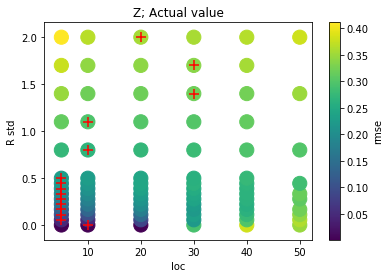

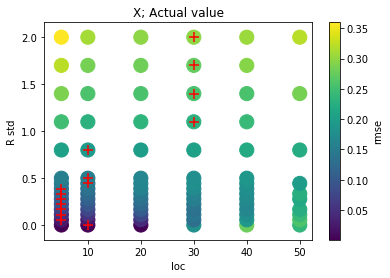

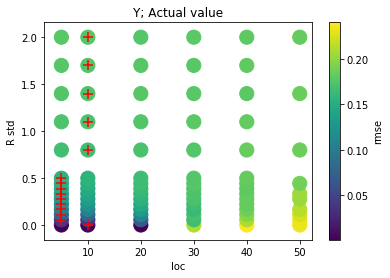

In [31]:
Z_scale = 1
X_scale = 1
Y_scale = 1

rmse_dict = {'Z': [stdrd_rmse_f, Z_scale],
             'X': [stdrd_rmse_fX, X_scale],
             'Y': [stdrd_rmse_fY, Y_scale]}

plot_points(rmse_dict, opt_alpha_mask, common_title='Actual value')

In [35]:
unique_Rstd

array([0.002     , 0.05733333, 0.11266667, 0.168     , 0.22333333,
       0.27866667, 0.334     , 0.38933333, 0.44466667, 0.5       ,
       0.8       , 1.1       , 1.4       , 1.7       , 2.        ])

[0.00024506 0.05770605 0.00020361 0.04403086 0.05258096 0.0002014
 0.00715262 0.00755286 0.05487607 0.01279512 0.03352229 0.04512467
 0.01380619 0.01489722 0.05179984 0.02127824 0.03505769 0.0419349
 0.0191206  0.02052775 0.04878496 0.02644269 0.03338449 0.03968494
 0.02487912 0.03001932 0.03432034 0.03905606 0.0233433  0.02722141
 0.03223708 0.04668288 0.03643867 0.03969488 0.02613762 0.02958438
 0.04805168 0.03404387 0.03721413 0.03993978 0.02860288 0.03589778
 0.03844122 0.04013052 0.03095147 0.03158412 0.03679493 0.0396545
 0.04044659 0.04312401 0.03291763 0.03317161 0.03697425 0.03952127
 0.04175807 0.0344061  0.03445095 0.04487044 0.04539325 0.0414916
 0.04043001 0.04125197 0.04248852 0.04733509 0.04496583 0.04565939
 0.04559436 0.04739171 0.05295747 0.0525681  0.04850495 0.04855992
 0.04843229 0.04892026 0.05381735 0.05703047 0.05184334 0.05156478
 0.05102881 0.05742559 0.06216062 0.05549153 0.05386536 0.05403519
 0.05519635]
[0.00011741 0.04226417 0.00010288 0.02742481 0.036000

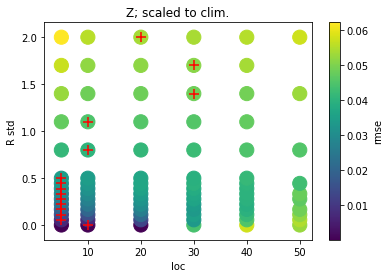

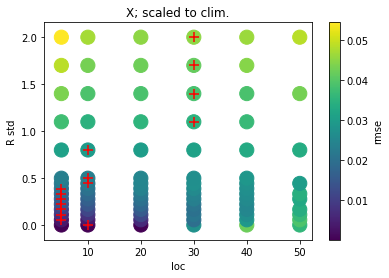

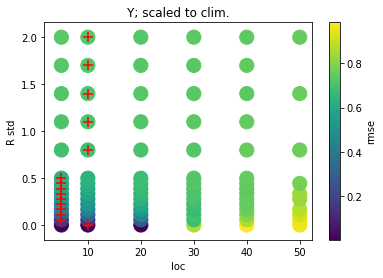

In [32]:
Z_scale = np.sqrt(2) * 4.678
X_scale = np.sqrt(2) * 4.668
Y_scale = np.sqrt(2) * 0.1724

rmse_dict = {'Z': [stdrd_rmse_f, Z_scale],
             'X': [stdrd_rmse_fX, X_scale],
             'Y': [stdrd_rmse_fY, Y_scale]}

plot_points(rmse_dict, opt_alpha_mask, common_title='scaled to clim.')

[0.00162127 0.38176539 0.00134705 0.29129456 0.34785942 0.00133239
 0.04731951 0.0499674  0.36304311 0.08464856 0.2217731  0.29853086
 0.09133749 0.09855541 0.34269174 0.14077029 0.23193082 0.27742832
 0.12649597 0.13580523 0.3227462  0.17493669 0.22086145 0.2625433
 0.16459255 0.19859853 0.22705276 0.25838281 0.15443205 0.18008845
 0.21327057 0.3088395  0.241067   0.26260909 0.17291839 0.19572115
 0.31789508 0.22522376 0.24619719 0.26422925 0.18922783 0.23748862
 0.25431522 0.2654911  0.20476539 0.20895076 0.24342388 0.26234192
 0.26758212 0.28529512 0.21777287 0.21945313 0.24461022 0.2614605
 0.2762585  0.22762016 0.22791687 0.296849   0.30030773 0.27449562
 0.26747248 0.2729103  0.28109089 0.31315435 0.29748002 0.30206844
 0.30163819 0.31352891 0.35035024 0.34777429 0.3208938  0.32125745
 0.32041308 0.32364131 0.35603897 0.37729598 0.3429795  0.34113665
 0.33759087 0.37990997 0.41123548 0.36711479 0.35635657 0.35748012
 0.36516198]
[0.47807854 0.73083885 0.50418689 0.62152275 0.6832

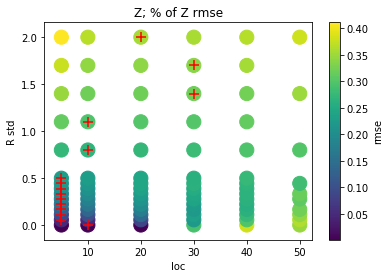

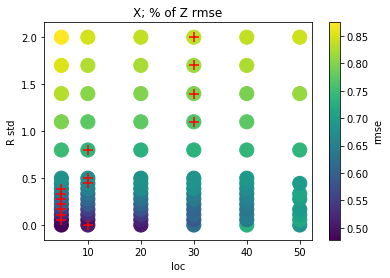

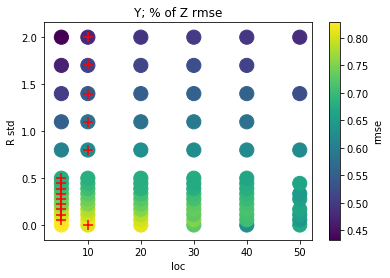

In [33]:
Z_scale = 1
X_scale = stdrd_rmse_f
Y_scale = stdrd_rmse_f

rmse_dict = {'Z': [stdrd_rmse_f, Z_scale],
             'X': [stdrd_rmse_fX, X_scale],
             'Y': [stdrd_rmse_fY, Y_scale]}

plot_points(rmse_dict, opt_alpha_mask, common_title='% of Z rmse')

[  1.02519331 368.09779565   1.15421264 210.62273144 301.8142091
   1.19690414   1.06213669   1.18129221  13.19133336   2.10307544
   6.30436117   9.23194025   1.09882784   1.23074291   6.96450196
   1.86135654   3.51529731   4.63840489   1.09838642   1.20777732
   4.70902876   1.65505945   2.40569052   3.11757338   1.32579493
   1.49030396   1.94757878   2.43383573   1.2144991    1.25262728
   1.57661782   2.99322783   1.75454707   2.08809364   1.17071154
   1.20962206   2.95275525   1.46605868   1.57408042   1.8450473
   1.15758618   1.55983639   1.65620245   1.65548545   1.14876319
   1.31765863   1.47360843   1.56444761   1.71433631   1.72157431
   1.14637662   1.27589183   1.38343387   1.44204717   1.44512277
   1.14012466   1.25453542   1.46567456   1.40749367   1.120542
   1.1842967    1.3198527    1.44569579   1.12990823   1.16252935
   1.26763835   1.33852443   1.45350649   1.19165932   1.1328515
   1.13140285   1.21288019   1.266237     1.33704613   1.19597923
   1.13331477  

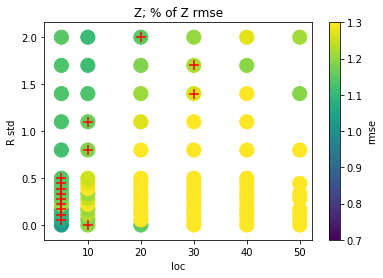

In [34]:
Z_scale = np.array(stdrd_std_f)
# X_scale = stdrd_rmse_f
# Y_scale = stdrd_rmse_f

# rmse_dict = {'Z': [stdrd_rmse_f, Z_scale],
#              'X': [stdrd_rmse_fX, X_scale],
#              'Y': [stdrd_rmse_fY, Y_scale]}
rmse_dict = {'Z': [stdrd_rmse_f, Z_scale]}

plot_points(rmse_dict, opt_alpha_mask, common_title='% of Z rmse',
            vmin=0.7, vmax=1.3)

In [ ]:
dt approx .01

[0.00045397 0.00044038 0.33148549 0.00063903 0.00066909 0.01323609
 0.01194537 0.01753988 0.02060367 0.0266292  0.02690559 0.30633752
 0.03972756 0.06549448 0.14315093 0.0427227  0.04506808 0.30751
 0.06768893 0.10118942 0.16522889 0.33114998 0.06543254 0.06421687
 0.09392817 0.12844793 0.17257209 0.07181781 0.08433861 0.11624509
 0.15552824 0.18837307 0.08587848 0.0996862  0.13673982 0.16949605
 0.19591803 0.10228502 0.11100727 0.15106038 0.18730892 0.2082835
 0.11507057 0.12356724 0.16592676 0.19698853 0.21591531 0.23229585
 0.12704372 0.14337291 0.16835439 0.19982314 0.22516047 0.18218514
 0.1819465  0.20598204 0.22418357 0.25399231 0.28126619 0.22405939
 0.2163295  0.22828847 0.24552561 0.29467682 0.25662187 0.24615023
 0.24820961 0.25325697 0.27302272 0.28606746 0.27205158 0.26927161
 0.27158116 0.28455672 0.37865599 0.33772231 0.32844653 0.4277342 ]
[2.28979647e-04 2.32151372e-04 2.21323383e-01 2.94345665e-04
 3.26247379e-04 6.64257790e-03 6.25980002e-03 8.54234917e-03
 9.9364916

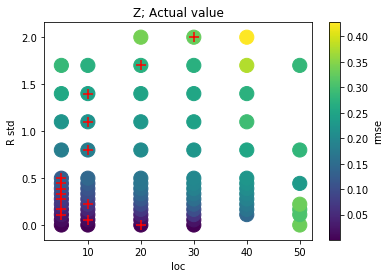

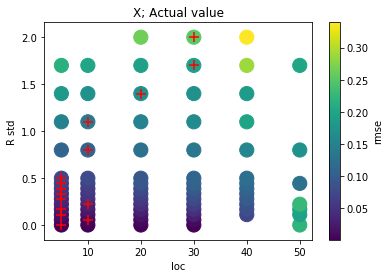

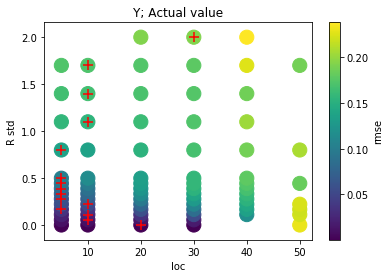

In [16]:
Z_scale = 1
X_scale = 1
Y_scale = 1

rmse_dict = {'Z': [stdrd_rmse_f, Z_scale],
             'X': [stdrd_rmse_fX, X_scale],
             'Y': [stdrd_rmse_fY, Y_scale]}

plot_points(rmse_dict, opt_alpha_mask, common_title='Actual value')

[6.86200901e-05 6.65667064e-05 5.01059507e-02 9.65937637e-05
 1.01136210e-04 2.00071230e-03 1.80561218e-03 2.65125468e-03
 3.11436413e-03 4.02515839e-03 4.06693590e-03 4.63046892e-02
 6.00505134e-03 9.89986979e-03 2.16380924e-02 6.45778396e-03
 6.81230094e-03 4.64819166e-02 1.02315730e-02 1.52953661e-02
 2.49753038e-02 5.00552365e-02 9.89050738e-03 9.70675142e-03
 1.41977866e-02 1.94156481e-02 2.60852710e-02 1.08556781e-02
 1.27482698e-02 1.75711190e-02 2.35089932e-02 2.84736805e-02
 1.29810295e-02 1.50681462e-02 2.06690152e-02 2.56203090e-02
 2.96141437e-02 1.54609728e-02 1.67793912e-02 2.28336508e-02
 2.83128273e-02 3.14832568e-02 1.73935834e-02 1.86779034e-02
 2.50807899e-02 2.97759566e-02 3.26368490e-02 3.51128620e-02
 1.92033945e-02 2.16716451e-02 2.54477411e-02 3.02044247e-02
 3.40343093e-02 2.75383390e-02 2.75022666e-02 3.11353784e-02
 3.38866438e-02 3.83924076e-02 4.25150122e-02 3.38678738e-02
 3.26994564e-02 3.45071232e-02 3.71126169e-02 4.45421074e-02
 3.87898819e-02 3.720703

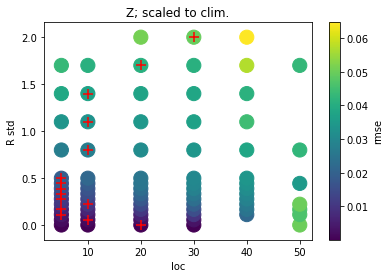

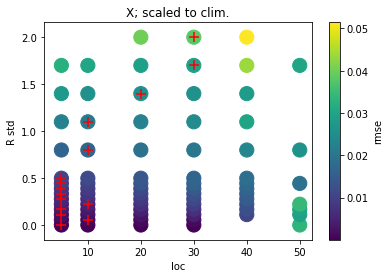

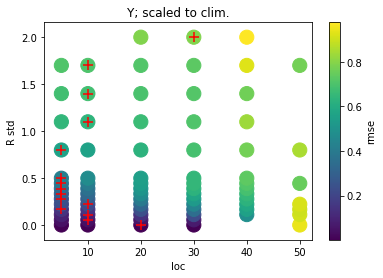

In [17]:
Z_scale = np.sqrt(2) * 4.678
X_scale = np.sqrt(2) * 4.668
Y_scale = np.sqrt(2) * 0.1724

rmse_dict = {'Z': [stdrd_rmse_f, Z_scale],
             'X': [stdrd_rmse_fX, X_scale],
             'Y': [stdrd_rmse_fY, Y_scale]}

plot_points(rmse_dict, opt_alpha_mask, common_title='scaled to clim.')

[0.00045397 0.00044038 0.33148549 0.00063903 0.00066909 0.01323609
 0.01194537 0.01753988 0.02060367 0.0266292  0.02690559 0.30633752
 0.03972756 0.06549448 0.14315093 0.0427227  0.04506808 0.30751
 0.06768893 0.10118942 0.16522889 0.33114998 0.06543254 0.06421687
 0.09392817 0.12844793 0.17257209 0.07181781 0.08433861 0.11624509
 0.15552824 0.18837307 0.08587848 0.0996862  0.13673982 0.16949605
 0.19591803 0.10228502 0.11100727 0.15106038 0.18730892 0.2082835
 0.11507057 0.12356724 0.16592676 0.19698853 0.21591531 0.23229585
 0.12704372 0.14337291 0.16835439 0.19982314 0.22516047 0.18218514
 0.1819465  0.20598204 0.22418357 0.25399231 0.28126619 0.22405939
 0.2163295  0.22828847 0.24552561 0.29467682 0.25662187 0.24615023
 0.24820961 0.25325697 0.27302272 0.28606746 0.27205158 0.26927161
 0.27158116 0.28455672 0.37865599 0.33772231 0.32844653 0.4277342 ]
[0.50439455 0.52715578 0.66767141 0.46060998 0.48760162 0.50185332
 0.52403557 0.48702433 0.48226803 0.50226208 0.5166957  0.6353398

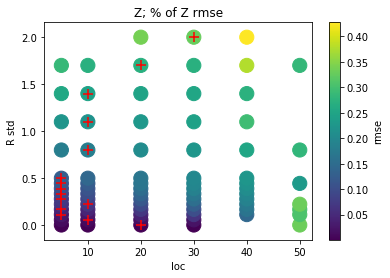

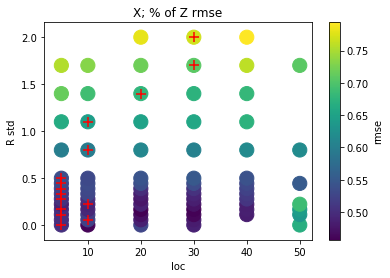

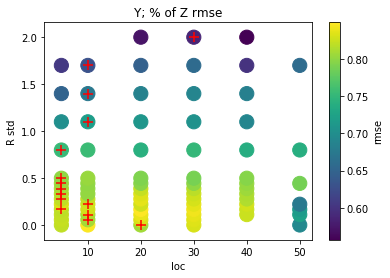

In [18]:
Z_scale = 1
X_scale = stdrd_rmse_f
Y_scale = stdrd_rmse_f

rmse_dict = {'Z': [stdrd_rmse_f, Z_scale],
             'X': [stdrd_rmse_fX, X_scale],
             'Y': [stdrd_rmse_fY, Y_scale]}

plot_points(rmse_dict, opt_alpha_mask, common_title='% of Z rmse')

In [35]:
print(stdrd_rmse_f/stdrd_std_f)

[9.93260687e-01            nan 7.43885308e+02 1.06115520e+03
            nan            nan 9.41366847e-01            nan
 1.14569226e+00 7.36856158e+02            nan 1.14797411e+03
 9.06272389e-01 9.56603603e-01 1.07809252e+00 4.18677923e+00
            nan            nan            nan 9.63507135e-01
 1.06417852e+00 1.18604719e+00            nan            nan
 1.00328905e+00 1.08779395e+00 2.71330058e+01 3.73977685e+01
            nan            nan 9.48752632e-01 1.01884993e+00
 1.92033914e+00 2.47638335e+01            nan            nan
 9.06239219e-01 9.68485831e-01 1.14717985e+00 2.06440076e+00
            nan            nan 9.13650767e-01 9.69212609e-01
 1.08494470e+00 1.26699537e+00            nan            nan
 1.01272662e+00 1.22445642e+00 1.27132196e+01 1.81095812e+01
            nan            nan            nan 1.03879772e+00
 4.80091749e+00 1.23173088e+01            nan 1.85915626e+01
 9.09466886e-01 9.81350414e-01 1.30433884e+00 4.76675149e+00
            nan         

[9.93260687e-01 1.14569226e+00 1.14797411e+03 9.56603603e-01
 1.18604719e+00 1.00328905e+00 1.08779395e+00 1.14717985e+00
 1.26699537e+00 1.01272662e+00 1.22445642e+00 1.85915626e+01
 1.30433884e+00 2.02962873e+00 4.97505126e+00 1.07493304e+00
 1.08272106e+00 1.24099589e+01 1.19175148e+00 2.09056432e+00
 3.82901553e+00 1.18585861e+01 9.91407192e-01 1.14630814e+00
 1.53618330e+00 1.98941992e+00 3.00438016e+00 1.06950647e+00
 1.19953609e+00 1.52008130e+00 1.92413631e+00 2.63389003e+00
 1.06329577e+00 1.45246080e+00 1.49369924e+00 1.75269493e+00
 2.28173676e+00 1.09275495e+00 1.38677804e+00 1.41829788e+00
 1.66339157e+00 2.08492489e+00 1.08670839e+00 1.36163016e+00
 1.83346230e+00 1.89558341e+00 1.89250059e+00 2.23970992e+00
 1.07702642e+00 1.15277271e+00 1.65774693e+00 1.71281773e+00
 1.75526029e+00 1.05052445e+00 1.19758841e+00 1.60807821e+00
 1.64339812e+00 1.55251501e+00 1.50101012e+00 1.02907570e+00
 1.12163547e+00 1.37755541e+00 1.64417483e+00 1.32223296e+00
 1.00299503e+00 1.078813

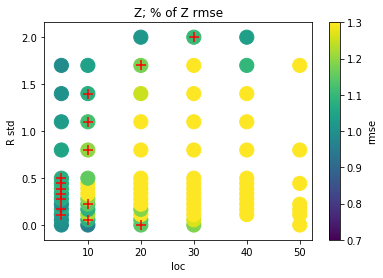

In [19]:
Z_scale = np.array(stdrd_std_f)
# X_scale = stdrd_rmse_f
# Y_scale = stdrd_rmse_f

# rmse_dict = {'Z': [stdrd_rmse_f, Z_scale],
#              'X': [stdrd_rmse_fX, X_scale],
#              'Y': [stdrd_rmse_fY, Y_scale]}
rmse_dict = {'Z': [stdrd_rmse_f, Z_scale]}

plot_points(rmse_dict, opt_alpha_mask, common_title='% of Z rmse',
            vmin=0.7, vmax=1.3)

In [37]:
this_Rstd = unique_Rstd[6]
this_loc = 10
this_mask = np.logical_and(stdrd_Rstd == this_Rstd,
                           stdrd_loc == this_loc)
temp = stdrd_rmse_f.copy()
temp[np.logical_not(this_mask)] = np.nan
this_argmin = np.nanargmin(temp)
this_alpha = stdrd_alpha[this_argmin]
print(this_alpha)

this_dir = stdrd_dirs[this_argmin]

0.1


In [38]:
this_path = os.path.join(this_dir, 'mu_f.nc')
this_mu_f = xr.open_dataarray(this_path)

this_path = os.path.join(this_dir, 'std_f.nc')
this_std_f = xr.open_dataarray(this_path)

this_path = os.path.join(this_dir, 'mu_a.nc')
this_mu_a = xr.open_dataarray(this_path)

this_path = os.path.join(this_dir, 'std_a.nc')
this_std_a = xr.open_dataarray(this_path)


this_mu_fX = utilities.window_sum_Z(this_mu_f, I=I, alpha=alpha, beta=beta)
this_mu_fY = this_mu_f - this_mu_fX

this_mu_aX = utilities.window_sum_Z(this_mu_a, I=I, alpha=alpha, beta=beta)
this_mu_aY = this_mu_a - this_mu_aX


this_mu_fX = utilities.window_sum_Z(this_mu_f, I=I, alpha=alpha, beta=beta)
this_mu_fY = this_mu_f - this_mu_fX

this_mu_aX = utilities.window_sum_Z(this_mu_a, I=I, alpha=alpha, beta=beta)
this_mu_aY = this_mu_a - this_mu_aX


this_rmse_f = ((this_mu_f - Zgt_ts.sel(time=this_mu_f.time))**2).mean(axis=0)
this_rmse_a = ((this_mu_a - Zgt_ts.sel(time=this_mu_a.time))**2).mean(axis=0)

this_rmse_fX = ((this_mu_fX - Xgt_ts.sel(time=this_mu_f.time))**2).mean(axis=0)
this_rmse_aX = ((this_mu_aX - Xgt_ts.sel(time=this_mu_a.time))**2).mean(axis=0)

this_rmse_fY = ((this_mu_fY - Ygt_ts.sel(time=this_mu_f.time))**2).mean(axis=0)
this_rmse_aY = ((this_mu_aY - Ygt_ts.sel(time=this_mu_a.time))**2).mean(axis=0)

this_std_f = np.sqrt((this_std_f**2).mean(axis=0))
this_std_a = np.sqrt((this_std_a**2).mean(axis=0))

this_path = os.path.join(this_dir, 'Zens_f_ts.nc')
this_Zens_f = xr.open_dataarray(this_path)

this_path = os.path.join(this_dir, 'Zens_a_ts.nc')
this_Zens_a = xr.open_dataarray(this_path)

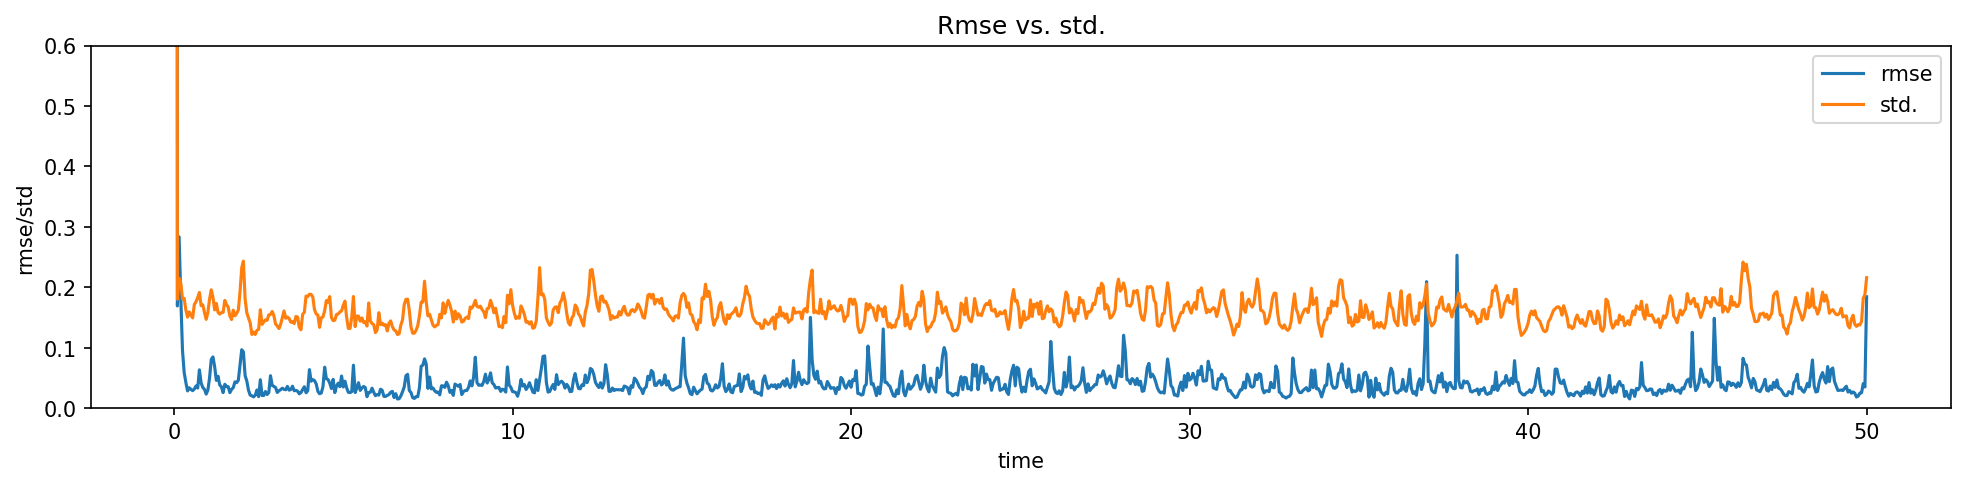

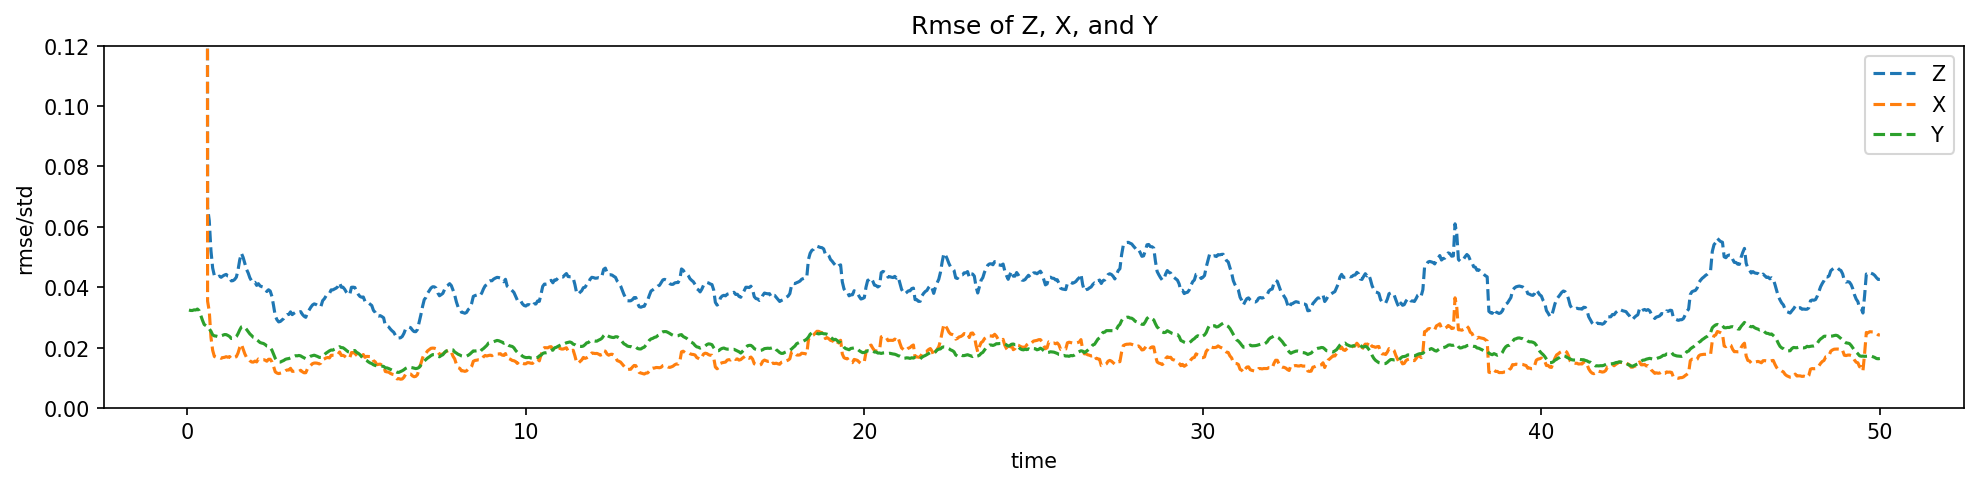

In [189]:
figsize = plt.figaspect(1/5)
dpi = 150
plt.figure(figsize=figsize, dpi=dpi)
plt.plot(t_kf[1:], this_rmse_f)
plt.plot(t_kf[1:], this_std_f)
plt.ylim([0, 0.6])
plt.title('Rmse vs. std.')
plt.ylabel('rmse/std')
plt.xlabel('time')
plt.legend(
    ['rmse',
     'std.'])

window = 20
plt.figure(figsize=figsize, dpi=dpi)
plt.plot(t_kf[1:], ndimage.uniform_filter1d(this_rmse_f, window), '--')
plt.plot(t_kf[1:], ndimage.uniform_filter1d(this_rmse_fX, window), '--')
plt.plot(t_kf[1:], ndimage.uniform_filter1d(this_rmse_fY, window), '--')
plt.ylim([0, 0.12])
plt.title('Rmse of Z, X, and Y')
plt.ylabel('rmse/std')
plt.xlabel('time')
plt.legend(
    ['Z',
     'X',
     'Y'])

In [190]:
this_Rstd = unique_Rstd[5]
this_loc = 5
this_mask = np.logical_and(stdrd_Rstd == this_Rstd,
                           stdrd_loc == this_loc)
temp = stdrd_rmse_f.copy()
temp[np.logical_not(this_mask)] = np.nan
this_argmin = np.nanargmin(temp)
this_alpha = stdrd_alpha[this_argmin]
print(this_alpha)

this_dir = stdrd_dirs[this_argmin]

0.25


In [194]:
this_path = os.path.join(this_dir, 'mu_f.nc')
this_mu_f = xr.open_dataarray(this_path)

this_path = os.path.join(this_dir, 'std_f.nc')
this_std_f = xr.open_dataarray(this_path)

this_path = os.path.join(this_dir, 'mu_a.nc')
this_mu_a = xr.open_dataarray(this_path)

this_path = os.path.join(this_dir, 'std_a.nc')
this_std_a = xr.open_dataarray(this_path)


this_mu_fX = utilities.window_sum_Z(this_mu_f, I=I, alpha=alpha, beta=beta)
this_mu_fY = this_mu_f - this_mu_fX

this_mu_aX = utilities.window_sum_Z(this_mu_a, I=I, alpha=alpha, beta=beta)
this_mu_aY = this_mu_a - this_mu_aX


this_mu_fX = utilities.window_sum_Z(this_mu_f, I=I, alpha=alpha, beta=beta)
this_mu_fY = this_mu_f - this_mu_fX

this_mu_aX = utilities.window_sum_Z(this_mu_a, I=I, alpha=alpha, beta=beta)
this_mu_aY = this_mu_a - this_mu_aX


this_rmse_f = ((this_mu_f - Zgt_ts.sel(time=this_mu_f.time))**2).mean(axis=0)
this_rmse_a = ((this_mu_a - Zgt_ts.sel(time=this_mu_a.time))**2).mean(axis=0)

this_rmse_fX = ((this_mu_fX - Xgt_ts.sel(time=this_mu_f.time))**2).mean(axis=0)
this_rmse_aX = ((this_mu_aX - Xgt_ts.sel(time=this_mu_a.time))**2).mean(axis=0)

this_rmse_fY = ((this_mu_fY - Ygt_ts.sel(time=this_mu_f.time))**2).mean(axis=0)
this_rmse_aY = ((this_mu_aY - Ygt_ts.sel(time=this_mu_a.time))**2).mean(axis=0)

this_std_f = np.sqrt((this_std_f**2).mean(axis=0))
this_std_a = np.sqrt((this_std_a**2).mean(axis=0))

this_path = os.path.join(this_dir, 'Zens_f_ts.nc')
this_Zens_f = xr.open_dataarray(this_path)

this_path = os.path.join(this_dir, 'Zens_a_ts.nc')
this_Zens_a = xr.open_dataarray(this_path)

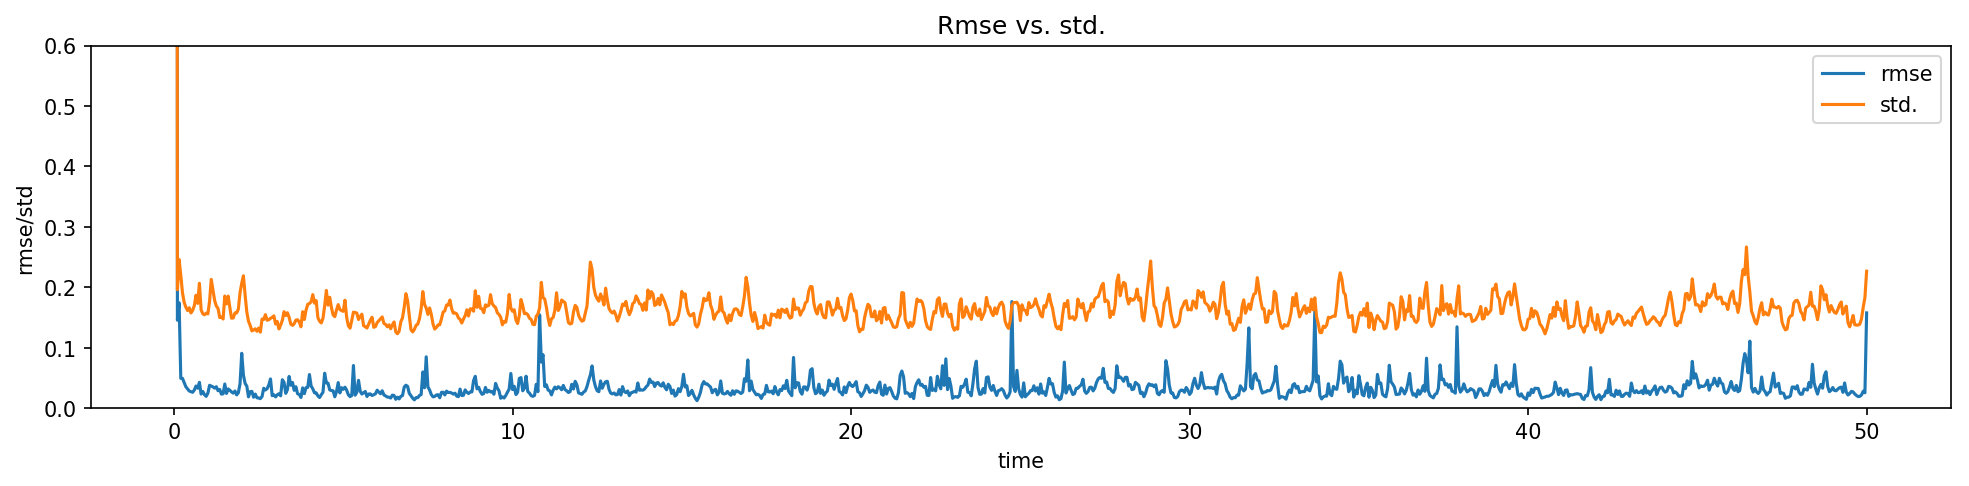

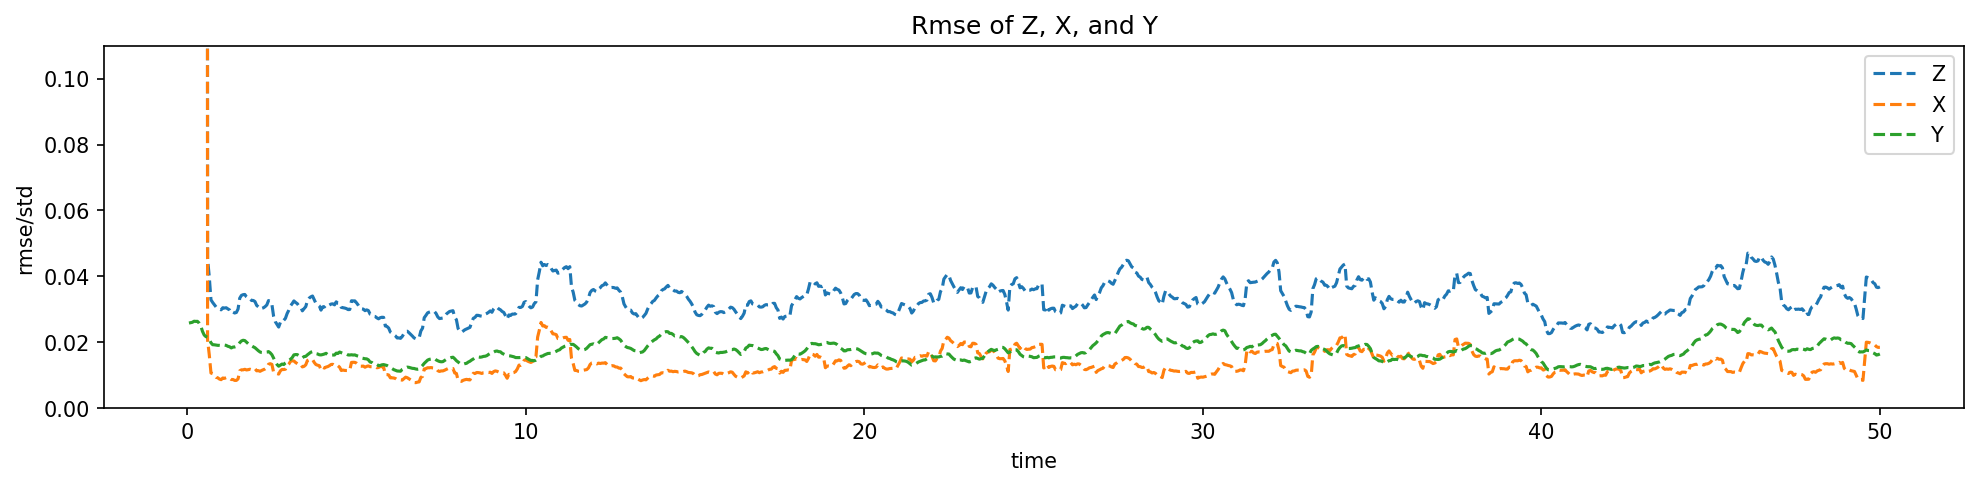

In [195]:
figsize = plt.figaspect(1/5)
dpi = 150
plt.figure(figsize=figsize, dpi=dpi)
plt.plot(t_kf[1:], this_rmse_f)
plt.plot(t_kf[1:], this_std_f)
plt.ylim([0, 0.6])
plt.title('Rmse vs. std.')
plt.ylabel('rmse/std')
plt.xlabel('time')
plt.legend(
    ['rmse',
     'std.'])

window = 20
plt.figure(figsize=figsize, dpi=dpi)
plt.plot(t_kf[1:], ndimage.uniform_filter1d(this_rmse_f, window), '--')
plt.plot(t_kf[1:], ndimage.uniform_filter1d(this_rmse_fX, window), '--')
plt.plot(t_kf[1:], ndimage.uniform_filter1d(this_rmse_fY, window), '--')
plt.ylim([0, 0.11])
plt.title('Rmse of Z, X, and Y')
plt.ylabel('rmse/std')
plt.xlabel('time')
plt.legend(
    ['Z',
     'X',
     'Y'])

In [196]:
this_Rstd = unique_Rstd[1]
this_loc = 5
this_mask = np.logical_and(stdrd_Rstd == this_Rstd,
                           stdrd_loc == this_loc)
temp = stdrd_rmse_f.copy()
temp[np.logical_not(this_mask)] = np.nan
this_argmin = np.nanargmin(temp)
this_alpha = stdrd_alpha[this_argmin]
print(this_alpha)

this_dir = stdrd_dirs[this_argmin]

0.25


In [197]:
this_path = os.path.join(this_dir, 'mu_f.nc')
this_mu_f = xr.open_dataarray(this_path)

this_path = os.path.join(this_dir, 'std_f.nc')
this_std_f = xr.open_dataarray(this_path)

this_path = os.path.join(this_dir, 'mu_a.nc')
this_mu_a = xr.open_dataarray(this_path)

this_path = os.path.join(this_dir, 'std_a.nc')
this_std_a = xr.open_dataarray(this_path)


this_mu_fX = utilities.window_sum_Z(this_mu_f, I=I, alpha=alpha, beta=beta)
this_mu_fY = this_mu_f - this_mu_fX

this_mu_aX = utilities.window_sum_Z(this_mu_a, I=I, alpha=alpha, beta=beta)
this_mu_aY = this_mu_a - this_mu_aX


this_mu_fX = utilities.window_sum_Z(this_mu_f, I=I, alpha=alpha, beta=beta)
this_mu_fY = this_mu_f - this_mu_fX

this_mu_aX = utilities.window_sum_Z(this_mu_a, I=I, alpha=alpha, beta=beta)
this_mu_aY = this_mu_a - this_mu_aX


this_rmse_f = ((this_mu_f - Zgt_ts.sel(time=this_mu_f.time))**2).mean(axis=0)
this_rmse_a = ((this_mu_a - Zgt_ts.sel(time=this_mu_a.time))**2).mean(axis=0)

this_rmse_fX = ((this_mu_fX - Xgt_ts.sel(time=this_mu_f.time))**2).mean(axis=0)
this_rmse_aX = ((this_mu_aX - Xgt_ts.sel(time=this_mu_a.time))**2).mean(axis=0)

this_rmse_fY = ((this_mu_fY - Ygt_ts.sel(time=this_mu_f.time))**2).mean(axis=0)
this_rmse_aY = ((this_mu_aY - Ygt_ts.sel(time=this_mu_a.time))**2).mean(axis=0)

this_std_f = np.sqrt((this_std_f**2).mean(axis=0))
this_std_a = np.sqrt((this_std_a**2).mean(axis=0))

this_path = os.path.join(this_dir, 'Zens_f_ts.nc')
this_Zens_f = xr.open_dataarray(this_path)

this_path = os.path.join(this_dir, 'Zens_a_ts.nc')
this_Zens_a = xr.open_dataarray(this_path)

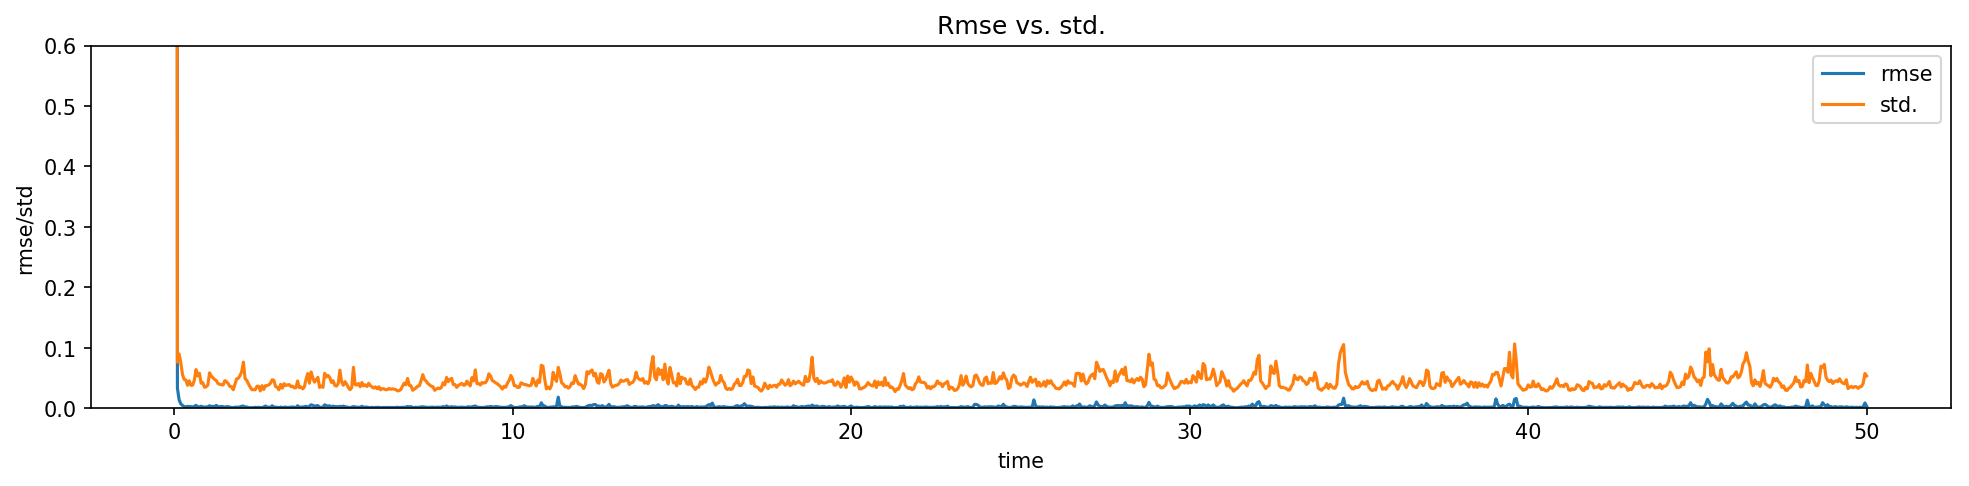

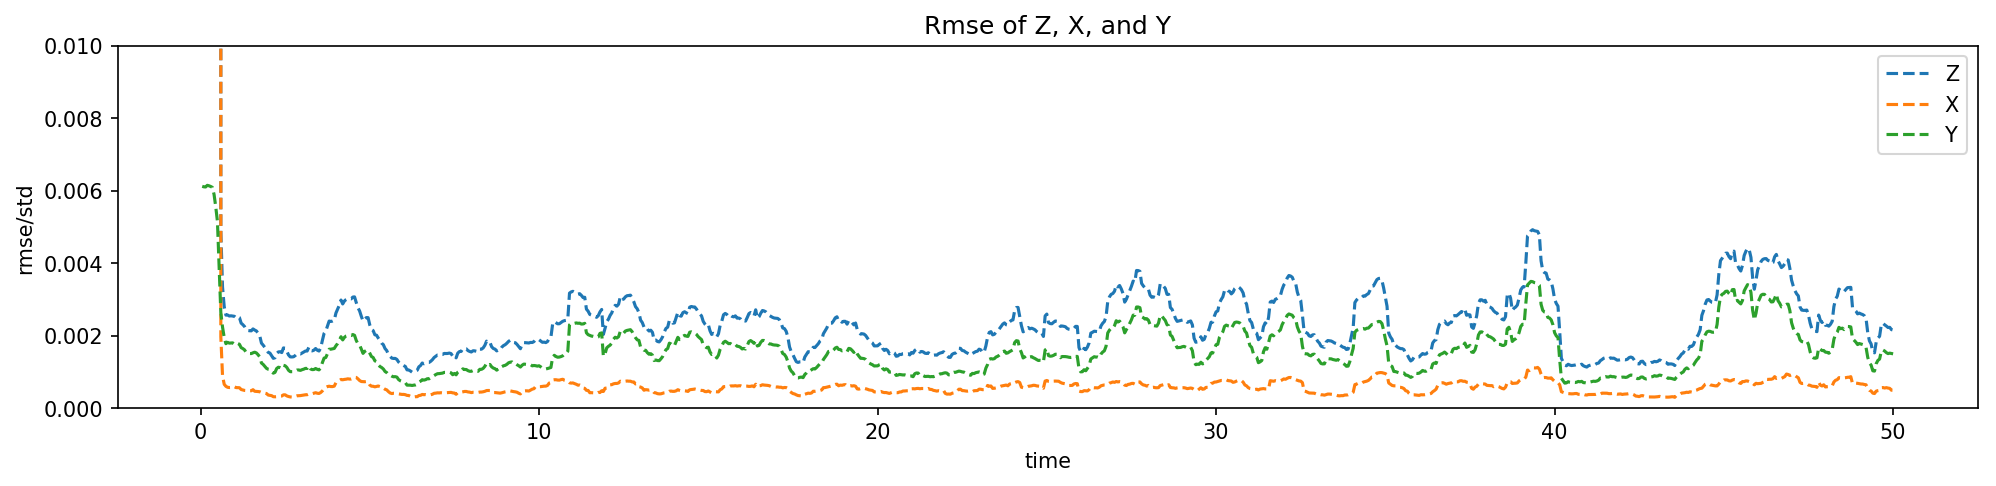

In [198]:
figsize = plt.figaspect(1/5)
dpi = 150
plt.figure(figsize=figsize, dpi=dpi)
plt.plot(t_kf[1:], this_rmse_f)
plt.plot(t_kf[1:], this_std_f)
plt.ylim([0, 0.6])
plt.title('Rmse vs. std.')
plt.ylabel('rmse/std')
plt.xlabel('time')
plt.legend(
    ['rmse',
     'std.'])

window = 20
plt.figure(figsize=figsize, dpi=dpi)
plt.plot(t_kf[1:], ndimage.uniform_filter1d(this_rmse_f, window), '--')
plt.plot(t_kf[1:], ndimage.uniform_filter1d(this_rmse_fX, window), '--')
plt.plot(t_kf[1:], ndimage.uniform_filter1d(this_rmse_fY, window), '--')
plt.ylim([0, 0.01])
plt.title('Rmse of Z, X, and Y')
plt.ylabel('rmse/std')
plt.xlabel('time')
plt.legend(
    ['Z',
     'X',
     'Y'])

In [199]:
this_Rstd = 0.8
this_loc = 30
this_mask = np.logical_and(stdrd_Rstd == this_Rstd,
                           stdrd_loc == this_loc)
temp = stdrd_rmse_f.copy()
temp[np.logical_not(this_mask)] = np.nan
this_argmin = np.nanargmin(temp)
this_alpha = stdrd_alpha[this_argmin]
print(this_alpha)

this_dir = stdrd_dirs[this_argmin]

0.25


In [200]:
this_path = os.path.join(this_dir, 'mu_f.nc')
this_mu_f = xr.open_dataarray(this_path)

this_path = os.path.join(this_dir, 'std_f.nc')
this_std_f = xr.open_dataarray(this_path)

this_path = os.path.join(this_dir, 'mu_a.nc')
this_mu_a = xr.open_dataarray(this_path)

this_path = os.path.join(this_dir, 'std_a.nc')
this_std_a = xr.open_dataarray(this_path)


this_mu_fX = utilities.window_sum_Z(this_mu_f, I=I, alpha=alpha, beta=beta)
this_mu_fY = this_mu_f - this_mu_fX

this_mu_aX = utilities.window_sum_Z(this_mu_a, I=I, alpha=alpha, beta=beta)
this_mu_aY = this_mu_a - this_mu_aX


this_mu_fX = utilities.window_sum_Z(this_mu_f, I=I, alpha=alpha, beta=beta)
this_mu_fY = this_mu_f - this_mu_fX

this_mu_aX = utilities.window_sum_Z(this_mu_a, I=I, alpha=alpha, beta=beta)
this_mu_aY = this_mu_a - this_mu_aX


this_rmse_f = ((this_mu_f - Zgt_ts.sel(time=this_mu_f.time))**2).mean(axis=0)
this_rmse_a = ((this_mu_a - Zgt_ts.sel(time=this_mu_a.time))**2).mean(axis=0)

this_rmse_fX = ((this_mu_fX - Xgt_ts.sel(time=this_mu_f.time))**2).mean(axis=0)
this_rmse_aX = ((this_mu_aX - Xgt_ts.sel(time=this_mu_a.time))**2).mean(axis=0)

this_rmse_fY = ((this_mu_fY - Ygt_ts.sel(time=this_mu_f.time))**2).mean(axis=0)
this_rmse_aY = ((this_mu_aY - Ygt_ts.sel(time=this_mu_a.time))**2).mean(axis=0)

this_std_f = np.sqrt((this_std_f**2).mean(axis=0))
this_std_a = np.sqrt((this_std_a**2).mean(axis=0))

this_path = os.path.join(this_dir, 'Zens_f_ts.nc')
this_Zens_f = xr.open_dataarray(this_path)

this_path = os.path.join(this_dir, 'Zens_a_ts.nc')
this_Zens_a = xr.open_dataarray(this_path)

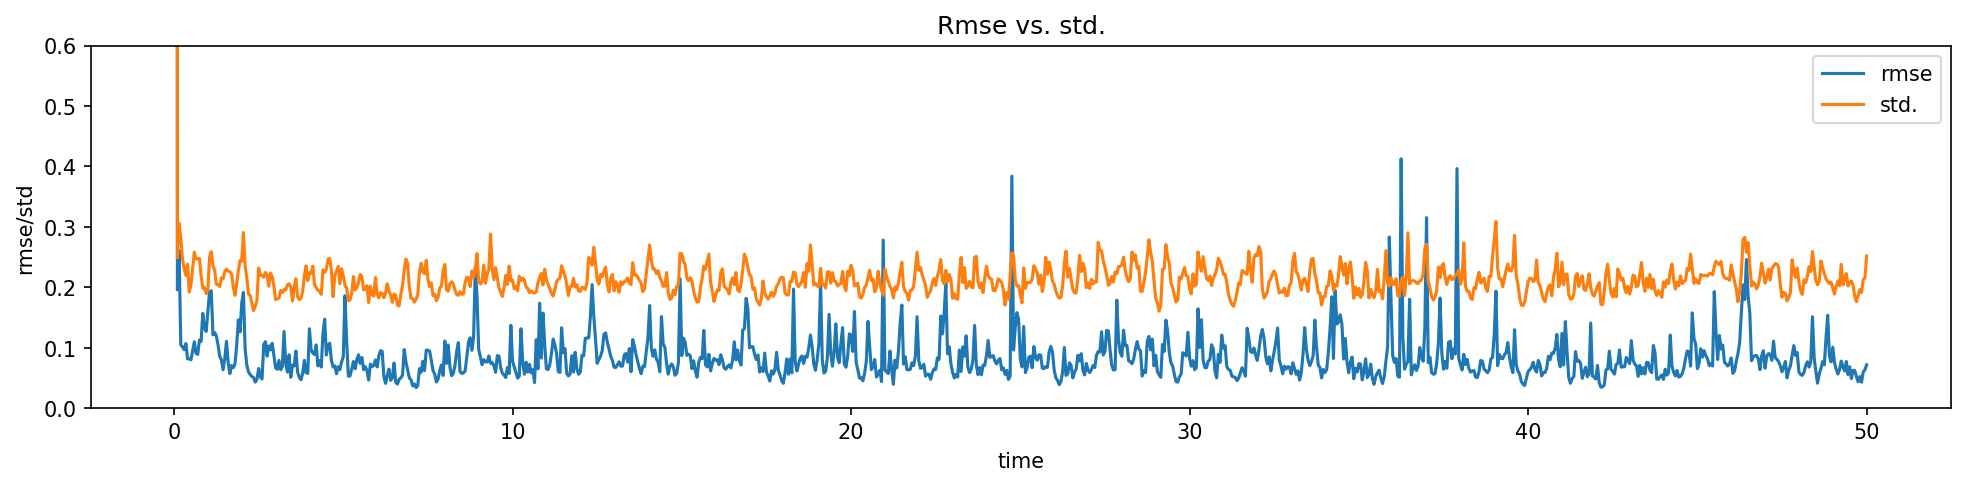

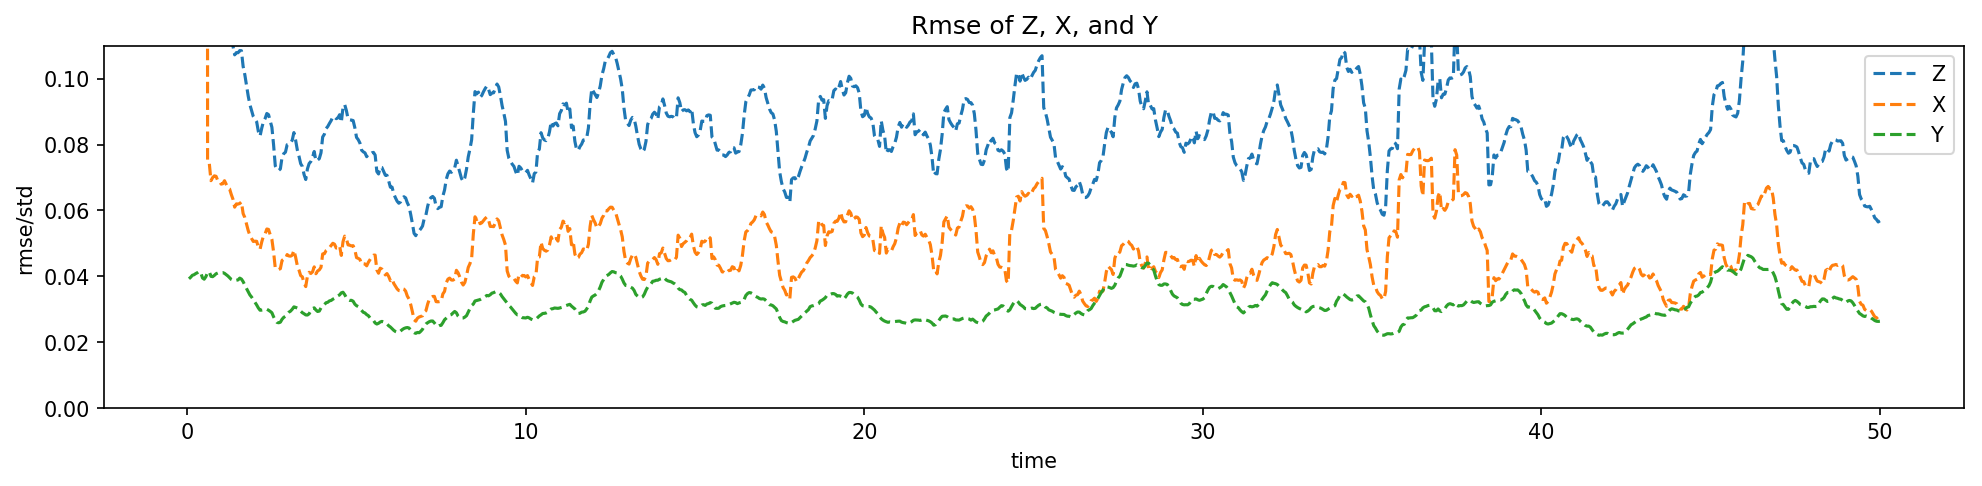

In [201]:
figsize = plt.figaspect(1/5)
dpi = 150
plt.figure(figsize=figsize, dpi=dpi)
plt.plot(t_kf[1:], this_rmse_f)
plt.plot(t_kf[1:], this_std_f)
plt.ylim([0, 0.6])
plt.title('Rmse vs. std.')
plt.ylabel('rmse/std')
plt.xlabel('time')
plt.legend(
    ['rmse',
     'std.'])

window = 20
plt.figure(figsize=figsize, dpi=dpi)
plt.plot(t_kf[1:], ndimage.uniform_filter1d(this_rmse_f, window), '--')
plt.plot(t_kf[1:], ndimage.uniform_filter1d(this_rmse_fX, window), '--')
plt.plot(t_kf[1:], ndimage.uniform_filter1d(this_rmse_fY, window), '--')
plt.ylim([0, 0.11])
plt.title('Rmse of Z, X, and Y')
plt.ylabel('rmse/std')
plt.xlabel('time')
plt.legend(
    ['Z',
     'X',
     'Y'])

In [206]:
this_Rstd = 0.8
this_loc = 30
this_alpha = 0.5
this_mask = np.logical_and(stdrd_Rstd == this_Rstd,
                           stdrd_loc == this_loc)
this_mask = np.logical_and(this_mask,
                           stdrd_alpha == this_alpha)
print(this_alpha)

this_dir = np.array(stdrd_dirs)[this_mask].item()

0.5


In [207]:
this_path = os.path.join(this_dir, 'mu_f.nc')
this_mu_f = xr.open_dataarray(this_path)

this_path = os.path.join(this_dir, 'std_f.nc')
this_std_f = xr.open_dataarray(this_path)

this_path = os.path.join(this_dir, 'mu_a.nc')
this_mu_a = xr.open_dataarray(this_path)

this_path = os.path.join(this_dir, 'std_a.nc')
this_std_a = xr.open_dataarray(this_path)


this_mu_fX = utilities.window_sum_Z(this_mu_f, I=I, alpha=alpha, beta=beta)
this_mu_fY = this_mu_f - this_mu_fX

this_mu_aX = utilities.window_sum_Z(this_mu_a, I=I, alpha=alpha, beta=beta)
this_mu_aY = this_mu_a - this_mu_aX


this_mu_fX = utilities.window_sum_Z(this_mu_f, I=I, alpha=alpha, beta=beta)
this_mu_fY = this_mu_f - this_mu_fX

this_mu_aX = utilities.window_sum_Z(this_mu_a, I=I, alpha=alpha, beta=beta)
this_mu_aY = this_mu_a - this_mu_aX


this_rmse_f = ((this_mu_f - Zgt_ts.sel(time=this_mu_f.time))**2).mean(axis=0)
this_rmse_a = ((this_mu_a - Zgt_ts.sel(time=this_mu_a.time))**2).mean(axis=0)

this_rmse_fX = ((this_mu_fX - Xgt_ts.sel(time=this_mu_f.time))**2).mean(axis=0)
this_rmse_aX = ((this_mu_aX - Xgt_ts.sel(time=this_mu_a.time))**2).mean(axis=0)

this_rmse_fY = ((this_mu_fY - Ygt_ts.sel(time=this_mu_f.time))**2).mean(axis=0)
this_rmse_aY = ((this_mu_aY - Ygt_ts.sel(time=this_mu_a.time))**2).mean(axis=0)

this_std_f = np.sqrt((this_std_f**2).mean(axis=0))
this_std_a = np.sqrt((this_std_a**2).mean(axis=0))

this_path = os.path.join(this_dir, 'Zens_f_ts.nc')
this_Zens_f = xr.open_dataarray(this_path)

this_path = os.path.join(this_dir, 'Zens_a_ts.nc')
this_Zens_a = xr.open_dataarray(this_path)

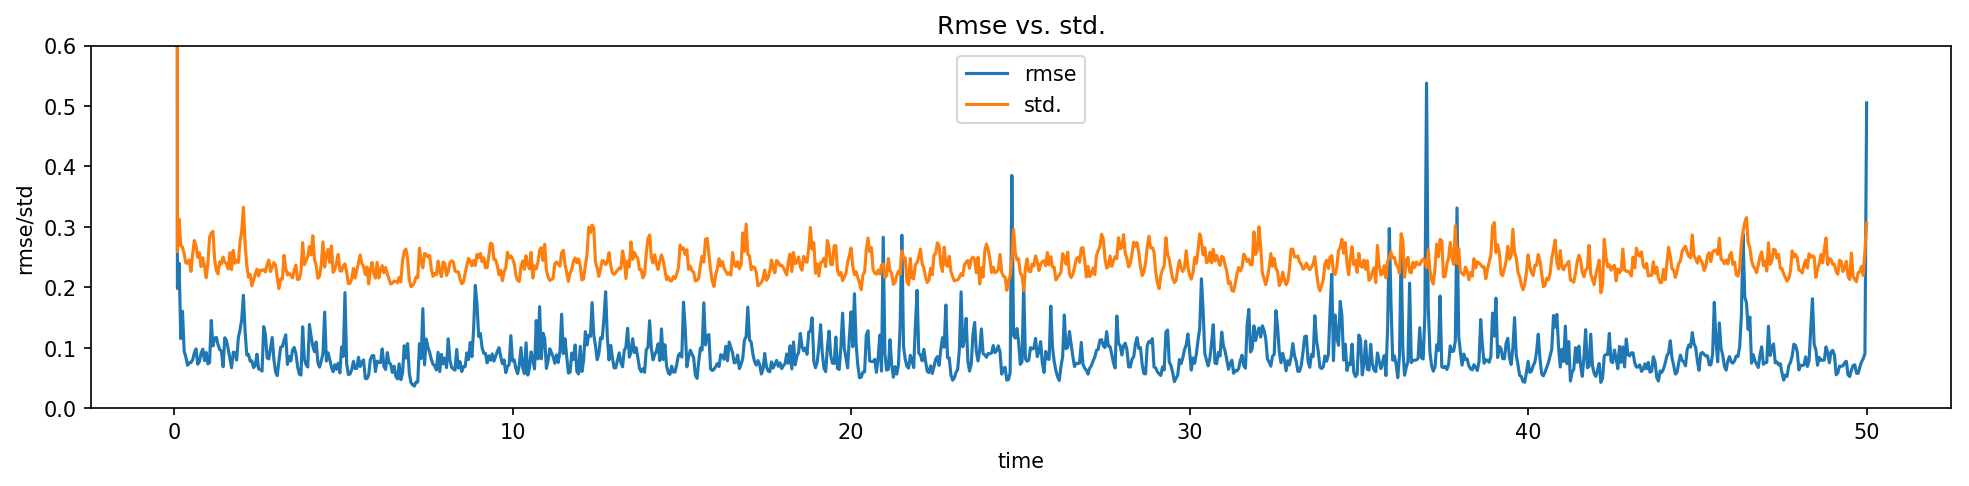

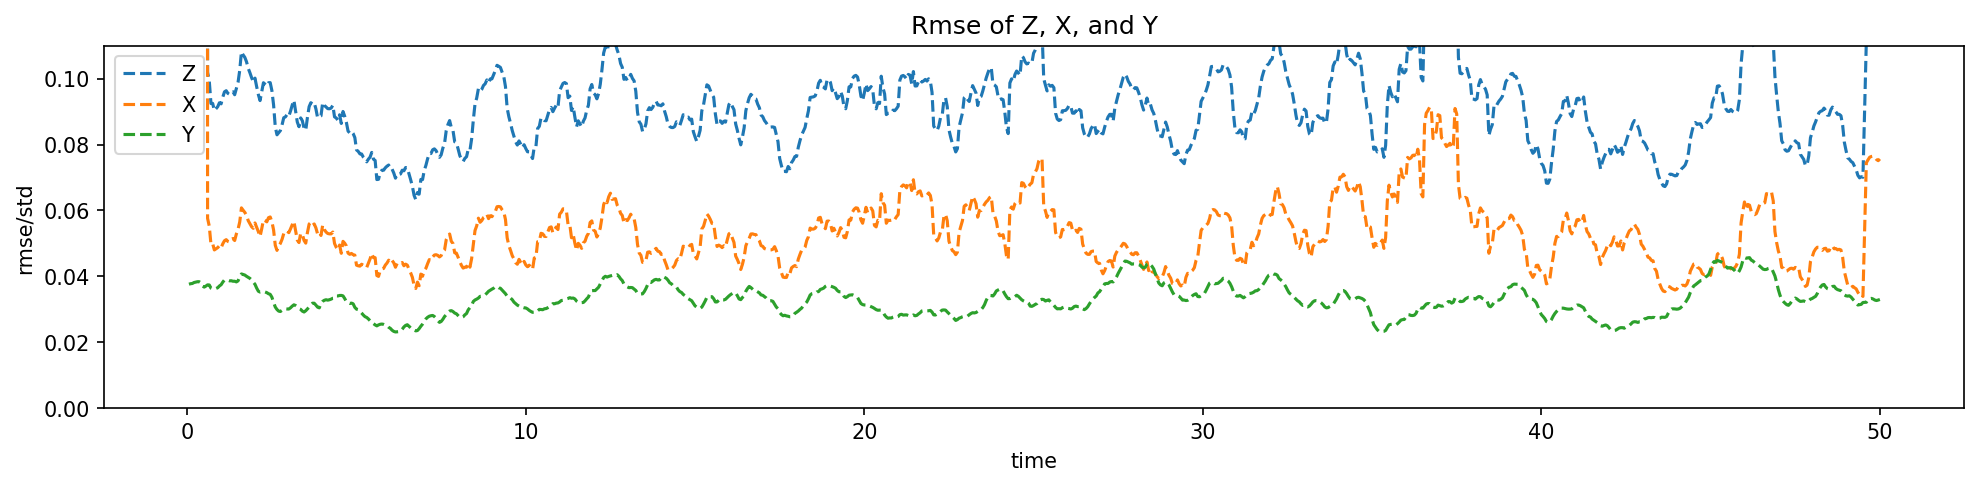

In [208]:
figsize = plt.figaspect(1/5)
dpi = 150
plt.figure(figsize=figsize, dpi=dpi)
plt.plot(t_kf[1:], this_rmse_f)
plt.plot(t_kf[1:], this_std_f)
plt.ylim([0, 0.6])
plt.title('Rmse vs. std.')
plt.ylabel('rmse/std')
plt.xlabel('time')
plt.legend(
    ['rmse',
     'std.'])

window = 20
plt.figure(figsize=figsize, dpi=dpi)
plt.plot(t_kf[1:], ndimage.uniform_filter1d(this_rmse_f, window), '--')
plt.plot(t_kf[1:], ndimage.uniform_filter1d(this_rmse_fX, window), '--')
plt.plot(t_kf[1:], ndimage.uniform_filter1d(this_rmse_fY, window), '--')
plt.ylim([0, 0.11])
plt.title('Rmse of Z, X, and Y')
plt.ylabel('rmse/std')
plt.xlabel('time')
plt.legend(
    ['Z',
     'X',
     'Y'])

In [209]:
this_Rstd = 0.8
this_loc = 30
this_alpha = 1.0
this_mask = np.logical_and(stdrd_Rstd == this_Rstd,
                           stdrd_loc == this_loc)
this_mask = np.logical_and(this_mask,
                           stdrd_alpha == this_alpha)
print(this_alpha)

this_dir = np.array(stdrd_dirs)[this_mask].item()

1.0


In [210]:
this_path = os.path.join(this_dir, 'mu_f.nc')
this_mu_f = xr.open_dataarray(this_path)

this_path = os.path.join(this_dir, 'std_f.nc')
this_std_f = xr.open_dataarray(this_path)

this_path = os.path.join(this_dir, 'mu_a.nc')
this_mu_a = xr.open_dataarray(this_path)

this_path = os.path.join(this_dir, 'std_a.nc')
this_std_a = xr.open_dataarray(this_path)


this_mu_fX = utilities.window_sum_Z(this_mu_f, I=I, alpha=alpha, beta=beta)
this_mu_fY = this_mu_f - this_mu_fX

this_mu_aX = utilities.window_sum_Z(this_mu_a, I=I, alpha=alpha, beta=beta)
this_mu_aY = this_mu_a - this_mu_aX


this_mu_fX = utilities.window_sum_Z(this_mu_f, I=I, alpha=alpha, beta=beta)
this_mu_fY = this_mu_f - this_mu_fX

this_mu_aX = utilities.window_sum_Z(this_mu_a, I=I, alpha=alpha, beta=beta)
this_mu_aY = this_mu_a - this_mu_aX


this_rmse_f = ((this_mu_f - Zgt_ts.sel(time=this_mu_f.time))**2).mean(axis=0)
this_rmse_a = ((this_mu_a - Zgt_ts.sel(time=this_mu_a.time))**2).mean(axis=0)

this_rmse_fX = ((this_mu_fX - Xgt_ts.sel(time=this_mu_f.time))**2).mean(axis=0)
this_rmse_aX = ((this_mu_aX - Xgt_ts.sel(time=this_mu_a.time))**2).mean(axis=0)

this_rmse_fY = ((this_mu_fY - Ygt_ts.sel(time=this_mu_f.time))**2).mean(axis=0)
this_rmse_aY = ((this_mu_aY - Ygt_ts.sel(time=this_mu_a.time))**2).mean(axis=0)

this_std_f = np.sqrt((this_std_f**2).mean(axis=0))
this_std_a = np.sqrt((this_std_a**2).mean(axis=0))

this_path = os.path.join(this_dir, 'Zens_f_ts.nc')
this_Zens_f = xr.open_dataarray(this_path)

this_path = os.path.join(this_dir, 'Zens_a_ts.nc')
this_Zens_a = xr.open_dataarray(this_path)

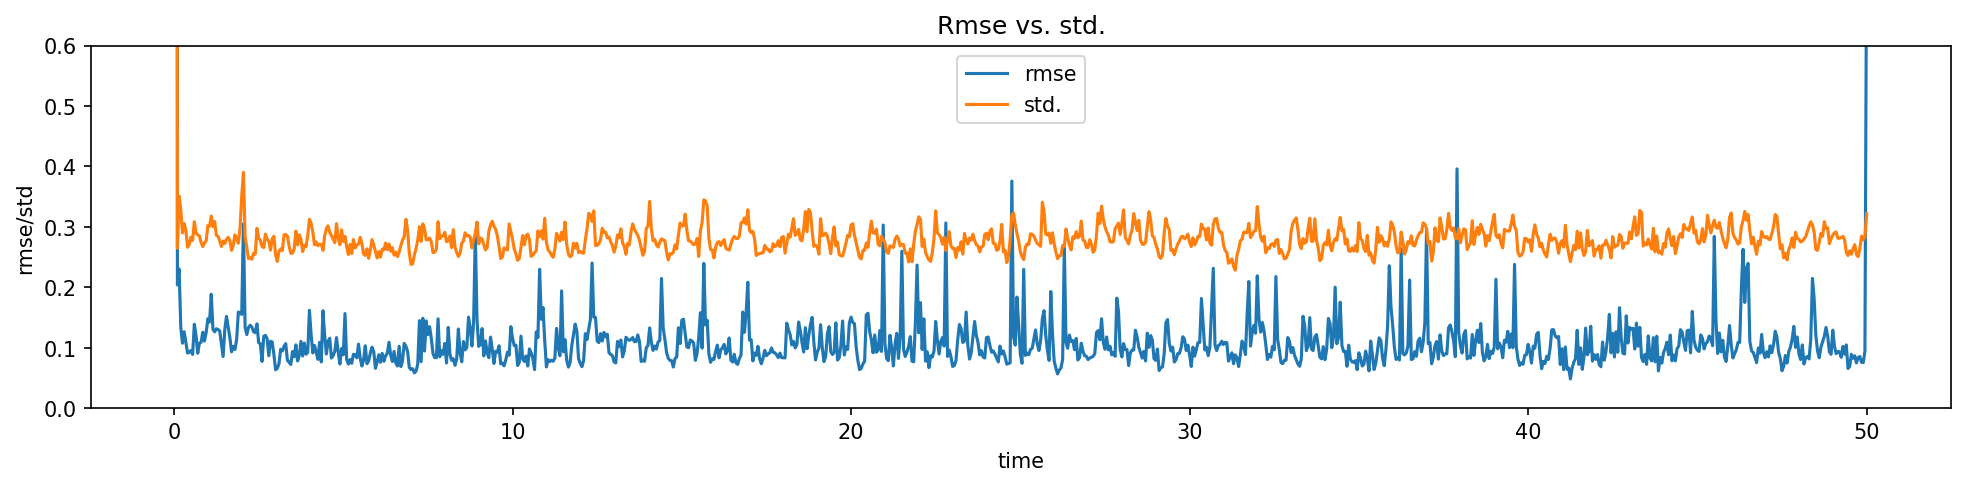

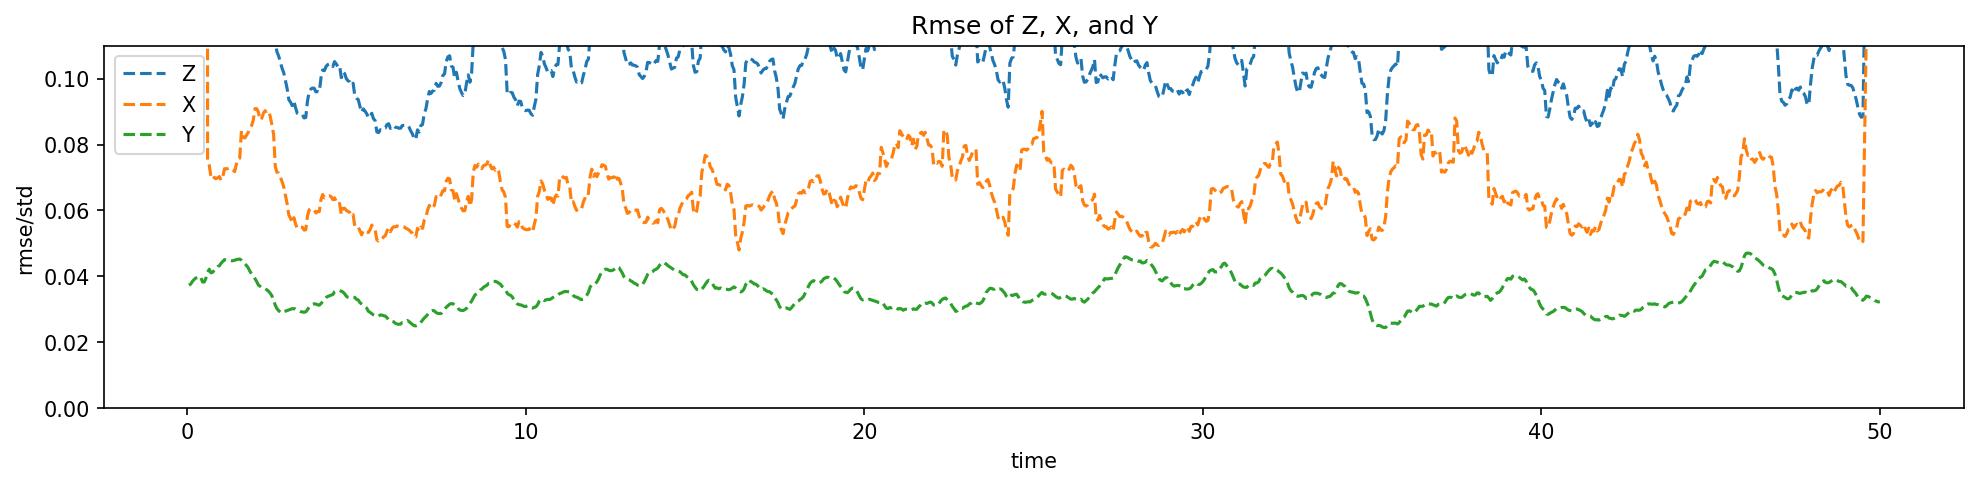

In [211]:
figsize = plt.figaspect(1/5)
dpi = 150
plt.figure(figsize=figsize, dpi=dpi)
plt.plot(t_kf[1:], this_rmse_f)
plt.plot(t_kf[1:], this_std_f)
plt.ylim([0, 0.6])
plt.title('Rmse vs. std.')
plt.ylabel('rmse/std')
plt.xlabel('time')
plt.legend(
    ['rmse',
     'std.'])

window = 20
plt.figure(figsize=figsize, dpi=dpi)
plt.plot(t_kf[1:], ndimage.uniform_filter1d(this_rmse_f, window), '--')
plt.plot(t_kf[1:], ndimage.uniform_filter1d(this_rmse_fX, window), '--')
plt.plot(t_kf[1:], ndimage.uniform_filter1d(this_rmse_fY, window), '--')
plt.ylim([0, 0.11])
plt.title('Rmse of Z, X, and Y')
plt.ylabel('rmse/std')
plt.xlabel('time')
plt.legend(
    ['Z',
     'X',
     'Y'])